In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold, KFold

from scipy.stats import ks_2samp
import tqdm

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',130)

### Utility Function

In [2]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [3]:
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

### 데이터 Load

In [ ]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

### 기본 전처리

In [ ]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime(2012,4,1) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['reference_date'] = (df['year']+(df['month'] - df['month_lag'])//12)*100 + (((df['month'] - df['month_lag'])%12) + 1)*1
    return df

In [ ]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [ ]:
historical_trans_df = historical_trans_df.sort_values('purchase_date')
new_merchant_trans_df = new_merchant_trans_df.sort_values('purchase_date')

In [ ]:
#historical_trans_df = pd.get_dummies(historical_trans_df, columns=['category_2', 'category_3'])
#new_merchant_trans_df = pd.get_dummies(new_merchant_trans_df, columns=['category_2', 'category_3'])

In [ ]:
authorized_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 1]
historical_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 0]

### Feature Engineering

In [ ]:
all_df = pd.concat([train_df,test_df])

In [ ]:
historical_trans_df.loc[historical_trans_df['installments']==999,'installments_999'] = 1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = 1

historical_trans_df.loc[historical_trans_df['installments']==999,'installments'] = -1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = -1

In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count','mean'])
group_df['card_id_month_lag_purchase_amount_count'] = group_df['card_id_month_lag_purchase_amount_count']/(1-group_df['month_lag'])
group_df['card_id_month_lag_purchase_amount_mean'] = group_df['card_id_month_lag_purchase_amount_mean']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_count',['sum','mean','std'])
mean_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_mean',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')
all_df = all_df.merge(mean_df, on=['card_id'], how='left')

In [ ]:
group_df = groupby_helper(historical_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month',['nunique','max','min','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'subsector_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'subsector_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'state_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'state_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'merchant_category_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'subsector_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'state_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

In [ ]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [ ]:
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_min']).dt.days
all_df = all_df.merge(historical_trans_group_df, on=['card_id'], how='left')

In [ ]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
#aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [ ]:
new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] = (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average'] = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
#merge with train, test
all_df = all_df.merge(new_merchant_trans_group_df, on=['card_id'], how='left')

In [ ]:
fill_new_hist_size = pd.read_csv('input/fill_new_hist_size_20190210_132027_cv3.397927.csv')
new_hist_card_id_size = pd.concat([all_df.loc[all_df['new_hist_card_id_size'].notnull(),['card_id','new_hist_card_id_size']],fill_new_hist_size])
all_df = all_df.merge(new_hist_card_id_size, on='card_id',how='left')
all_df['new_hist_card_id_size_x'] = all_df['new_hist_card_id_size_y']
del all_df['new_hist_card_id_size_y']
all_df.rename(columns={'new_hist_card_id_size_x':'new_hist_card_id_size'},inplace=True)

In [ ]:
fill_new_hist_date_max = pd.read_csv('input/fill_new_hist_card_id_purchase_date_max_20190210_140257_cv12.776013.csv')
new_hist_purchase_date_max = pd.concat([all_df.loc[all_df['new_hist_purchase_date_max'].notnull(),['card_id','new_hist_purchase_date_max']],fill_new_hist_date_max])
all_df = all_df.merge(new_hist_purchase_date_max, on='card_id',how='left')
all_df['new_hist_purchase_date_max_x'] = all_df['new_hist_purchase_date_max_y']
del all_df['new_hist_purchase_date_max_y']
all_df.rename(columns={'new_hist_purchase_date_max_x':'new_hist_purchase_date_max'},inplace=True)

In [ ]:
fill_new_hist_date_min = pd.read_csv('input/fill_new_hist_card_id_purchase_date_min_20190210_142523_cv11.764345.csv')
new_hist_purchase_date_min = pd.concat([all_df.loc[all_df['new_hist_purchase_date_min'].notnull(),['card_id','new_hist_purchase_date_min']],fill_new_hist_date_min])
all_df = all_df.merge(new_hist_purchase_date_min, on='card_id',how='left')
all_df['new_hist_purchase_date_min_x'] = all_df['new_hist_purchase_date_min_y']
del all_df['new_hist_purchase_date_min_y']
all_df.rename(columns={'new_hist_purchase_date_min_x':'new_hist_purchase_date_min'},inplace=True)

In [ ]:
all_df['new_hist_purchase_date_min'] = pd.to_datetime(all_df['new_hist_purchase_date_min'])
all_df['new_hist_purchase_date_max'] = pd.to_datetime(all_df['new_hist_purchase_date_max'])

In [ ]:
def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    #df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    #df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    df['elapsed_time'] = (datetime(2019,1, 20) - df['first_active_month']).dt.days
    #df['after_big_event'] = (datetime(2012,4, 1) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    df['year_month'] = df['year']*100 + df['month']
    df['hist_diff_reference_date_first'] = 12*(df['hist_reference_date_median']//100 - df['year_month']//100) + (df['hist_reference_date_median']%100 - df['year_month']%100)
    df['hist_diff_reference_date_last'] = 12*(df['hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['new_hist_diff_reference_date_first'] = 12*(df['new_hist_reference_date_median']//100 - df['year_month']//100) + (df['new_hist_reference_date_median']%100 - df['year_month']%100)
    df['new_hist_diff_reference_date_last'] = 12*(df['new_hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['new_hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['hist_diff_first_last'] = df['hist_diff_reference_date_first'] - df['hist_diff_reference_date_last'] 
    df['new_hist_diff_first_last'] = df['new_hist_diff_reference_date_first'] - df['new_hist_diff_reference_date_last'] 
    df['diff_new_hist_date_min_max'] = (df['new_hist_purchase_date_min'] - df['hist_purchase_date_max']).dt.days
    df['diff_new_hist_date_max_max'] = (df['new_hist_purchase_date_max'] - df['hist_purchase_date_max']).dt.days    
    
    
    df['hist_flag_ratio'] = df['hist_authorized_flag_sum'] / df['hist_card_id_size']
    #df['new_flag_ratio'] = df['new_hist_authorized_flag_sum'] / df['new_hist_card_id_size']
    #df['new_hist_flag_ratio'] = 1/(1+df['hist_flag_ratio'])
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_ratio'] = df['new_hist_card_id_size']/df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_hist_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_hist_purchase_amount_sum']/df['hist_purchase_amount_sum']
    
    df['month_diff_mean'] = df['new_hist_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_hist_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_hist_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_hist_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_hist_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_hist_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_hist_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_hist_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_hist_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_hist_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    
    #df['duration_mean'] = df['new_hist_duration_mean']+df['hist_duration_mean']
    #df['duration_min'] = df['new_hist_duration_min']+df['hist_duration_min']
    #df['duration_max'] = df['new_hist_duration_max']+df['hist_duration_max']
    #df['amount_month_ratio_mean']=df['new_hist_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    #df['amount_month_ratio_min']=df['new_hist_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    #df['amount_month_ratio_max']=df['new_hist_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_hist_card_id_size'] * df['new_hist_purchase_amount_sum'] / df['new_hist_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_size'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    
    del df['year']
    del df['year_month']
    del df['new_hist_reference_date_median']
    
    return df

In [ ]:
all_df = get_train_default_prorcessing(all_df)

In [ ]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'authorized_flag',['sum'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df['new_flag_ratio'] = all_df['new_hist_card_id_authorized_flag_sum'] / all_df['new_hist_card_id_size']
all_df['new_hist_flag_ratio'] = all_df['new_flag_ratio']/(all_df['new_flag_ratio']+all_df['hist_flag_ratio'])
del all_df['new_hist_card_id_authorized_flag_sum']

In [ ]:
all_df['feature123'] = all_df['feature_1'].astype(str) +'_'+all_df['feature_2'].astype(str)+'_'+all_df['feature_3'].astype(str)
all_df['feature123'] = pd.factorize(all_df['feature123'])[0]

In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'subsector_id',['nunique'])
group_df['card_id_month_lag_subsector_id_nunique'] = group_df['card_id_month_lag_subsector_id_nunique']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_subsector_id_nunique',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')

In [ ]:
group_df_mode = pd.read_csv('input/subsector_id_mode.csv')
group_df = groupby_helper(group_df_mode.reset_index(),'card_id', 'subsector_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

In [ ]:
group_df_mode_mci = pd.read_csv('input/merchant_category_id_mode.csv')
group_df = groupby_helper(group_df_mode_mci.reset_index(),'card_id', 'merchant_category_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

In [ ]:
all_df['feature123_frequency_encoding']= all_df['feature123'].map(all_df['feature123'].value_counts()/all_df.shape[0])

firstactive month보다 작거나 같은 달의 거래횟수 / 전체 거래횟수

In [ ]:
historical_trans_df =historical_trans_df.merge(all_df[['card_id','first_active_month','target','feature123']], on='card_id',how='left')
historical_trans_df['ym'] = historical_trans_df['purchase_date'].dt.year*100 + historical_trans_df['purchase_date'].dt.month
historical_trans_df['first_active_month_ym'] = historical_trans_df['first_active_month'].dt.year*100 + historical_trans_df['first_active_month'].dt.month
historical_trans_df['is_smaller_firstactive'] = 0
historical_trans_df.loc[historical_trans_df['ym']<=historical_trans_df['first_active_month_ym'],'is_smaller_firstactive'] = 1
group_df = groupby_helper(historical_trans_df,'card_id', 'is_smaller_firstactive',['sum'])
temp = groupby_helper(historical_trans_df,'card_id', 'card_id',['size'])
group_df = group_df.merge(temp, on='card_id', how='left')
group_df['before_firstactive_purchase_ratio']=group_df['card_id_is_smaller_firstactive_sum'] /group_df['card_id_card_id_size']
all_df = all_df.merge(group_df[['card_id','before_firstactive_purchase_ratio']], on=['card_id'], how='left')

In [ ]:
fill_new_hist_amount = pd.read_csv('input/fill_new_hist_purchase_amount_mean_20190210_153454_cv0.159328.csv')
new_hist_purchase_amount_mean = pd.concat([all_df.loc[all_df['new_hist_purchase_amount_mean'].notnull(),['card_id','new_hist_purchase_amount_mean']],fill_new_hist_amount])
all_df = all_df.merge(new_hist_purchase_amount_mean, on='card_id',how='left')
all_df['new_hist_purchase_amount_mean_x'] = all_df['new_hist_purchase_amount_mean_y']
del all_df['new_hist_purchase_amount_mean_y']
all_df.rename(columns={'new_hist_purchase_amount_mean_x':'new_hist_purchase_amount_mean'},inplace=True)

In [ ]:
group_df = historical_trans_df.groupby(['card_id'])['month_lag'].unique().reset_index()
group_df['month_lag_last'] = group_df['month_lag'].apply(lambda x: x[-1])

group_df['month_lag_last2month'] =group_df['month_lag'].apply(lambda x: x[-2:])
group_df['month_lag_last2month'] = group_df['month_lag_last2month'].apply(lambda x: x[0])
group_df['month_lag_last3month'] =group_df['month_lag'].apply(lambda x: x[-3:])
group_df['month_lag_last3month'] = group_df['month_lag_last3month'].apply(lambda x: x[0])
historical_trans_df = historical_trans_df.merge(group_df, on='card_id', how='left')
del historical_trans_df['month_lag_y']
historical_trans_df.rename(columns={'month_lag_x':'month_lag'},inplace=True)

In [ ]:
cat1_ratio = pd.read_csv('input/ratio_test.csv')
all_df = all_df.merge(cat1_ratio, on='card_id', how='left')

In [ ]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)&(historical_trans_df['category_1']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_all_before_1month'
prefix_2 = 'auth1_cat1_1_last_1month'
group_df = groupby_helper(last_month_minus1,'card_id','purchase_amount',['mean','count','sum'],prefix_1)
temp = groupby_helper(last_month,'card_id','purchase_amount',['mean','count','sum'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_purchase_amount_mean_ratio'.format(prefix_2)] =   group_df['{}_card_id_purchase_amount_mean'.format(prefix_1)] /group_df['{}_card_id_purchase_amount_mean'.format(prefix_2)]
group_df['{}_card_id_purchase_amount_count_ratio'.format(prefix_2)] =  group_df['{}_card_id_purchase_amount_count'.format(prefix_1)]/group_df['{}_card_id_purchase_amount_count'.format(prefix_2)]
group_df['{}_card_id_purchase_amount_sum_ratio'.format(prefix_2)] =  group_df['{}_card_id_purchase_amount_sum'.format(prefix_1)]/group_df['{}_card_id_purchase_amount_sum'.format(prefix_2)]

del group_df['{}_card_id_purchase_amount_mean'.format(prefix_1)], group_df['{}_card_id_purchase_amount_count'.format(prefix_1)], group_df['{}_card_id_purchase_amount_sum'.format(prefix_1)]
all_df = all_df.merge(group_df, on='card_id', how='left')

In [ ]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_cat1_1_all_before_1month'
prefix_2 = 'auth1_last_1month'
group_df = groupby_helper(last_month_minus1,'card_id','merchant_id',['nunique'],prefix_1)
temp = groupby_helper(last_month,'card_id','merchant_id',['nunique'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_merchant_id_nunique_ratio'.format(prefix_2)] =   group_df['{}_card_id_merchant_id_nunique'.format(prefix_1)] /group_df['{}_card_id_merchant_id_nunique'.format(prefix_2)]

all_df = all_df.merge(group_df, on='card_id', how='left')

In [ ]:
last_month_purchase_amount_ratio3 = pd.read_csv('input/last_month_purchase_amount_ratio3.csv')
all_df = all_df.merge(last_month_purchase_amount_ratio3, on='card_id', how='left')

In [ ]:
last_month_purchase_amount_ratio3 = pd.read_csv('input/last_month_purchase_amount_ratio.csv')
all_df = all_df.merge(last_month_purchase_amount_ratio3, on='card_id', how='left')

## 아래 피쳐는 Test 용으로 사용하면 안됩니다.

In [83]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_cat1_1_all_before_1month'
prefix_2 = 'auth1_last_1month'
group_df = groupby_helper(last_month_minus1,'card_id','installments',['mean','count','sum'],prefix_1)
temp = groupby_helper(last_month,'card_id','installments',['mean','count','sum'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_installments_mean_ratio'.format(prefix_2)] =   group_df['{}_card_id_installments_mean'.format(prefix_1)] /group_df['{}_card_id_installments_mean'.format(prefix_2)]
group_df['{}_card_id_installments_count_ratio'.format(prefix_2)] =  group_df['{}_card_id_installments_count'.format(prefix_1)]/group_df['{}_card_id_installments_count'.format(prefix_2)]
group_df['{}_card_id_installments_sum_ratio'.format(prefix_2)] =  group_df['{}_card_id_installments_sum'.format(prefix_1)]/group_df['{}_card_id_installments_sum'.format(prefix_2)]

del group_df['{}_card_id_installments_mean'.format(prefix_1)], group_df['{}_card_id_installments_count'.format(prefix_1)], group_df['{}_card_id_installments_sum'.format(prefix_1)]
all_df = all_df.merge(group_df, on='card_id', how='left')

card_id installments ['mean', 'count', 'sum']
card_id installments ['mean', 'count', 'sum']


In [122]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_cat1_1_all_before_1month'
prefix_2 = 'auth1_last_1month'
col = 'city_id'
group_df = groupby_helper(last_month_minus1,'card_id',col,['nunique'],prefix_1)
temp = groupby_helper(last_month,'card_id',col,['nunique'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_{}_nunique_ratio'.format(prefix_2,col)] =   group_df['{}_card_id_{}_nunique'.format(prefix_1,col)] /group_df['{}_card_id_{}_nunique'.format(prefix_2,col)]

all_df = all_df.merge(group_df, on='card_id', how='left')

card_id city_id ['nunique']
card_id city_id ['nunique']


In [127]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_cat1_1_all_before_1month'
prefix_2 = 'auth1_last_1month'
col = 'merchant_category_id'
group_df = groupby_helper(last_month_minus1,'card_id',col,['nunique'],prefix_1)
temp = groupby_helper(last_month,'card_id',col,['nunique'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_{}_nunique_ratio'.format(prefix_2,col)] =   group_df['{}_card_id_{}_nunique'.format(prefix_1,col)] /group_df['{}_card_id_{}_nunique'.format(prefix_2,col)]
#group_df['{}_card_id_{}_max_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_max'.format(prefix_1,col)]/group_df['{}_card_id_{}_max'.format(prefix_2,col)]
#group_df['{}_card_id_{}_min_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_min'.format(prefix_1,col)]/group_df['{}_card_id_{}_min'.format(prefix_2,col)]

#del group_df['{}_card_id_{}_nunique'.format(prefix_1,col)]#, group_df['{}_card_id_{}_max'.format(prefix_1,col)], group_df['{}_card_id_{}_min'.format(prefix_1,col)]
all_df = all_df.merge(group_df, on='card_id', how='left')

card_id merchant_category_id ['nunique']
card_id merchant_category_id ['nunique']


In [136]:
last_month = historical_trans_df.loc[(historical_trans_df['month_lag']==historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]
last_month_minus1 = historical_trans_df.loc[(historical_trans_df['month_lag']<historical_trans_df['month_lag_last'])&(historical_trans_df['authorized_flag']==1)]

prefix_1 = 'auth1_cat1_1_all_before_1month'
prefix_2 = 'auth1_last_1month'
col = 'subsector_id'
group_df = groupby_helper(last_month_minus1,'card_id',col,['nunique'],prefix_1)
temp = groupby_helper(last_month,'card_id',col,['nunique'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_{}_nunique_ratio'.format(prefix_2,col)] =   group_df['{}_card_id_{}_nunique'.format(prefix_1,col)] /group_df['{}_card_id_{}_nunique'.format(prefix_2,col)]
#group_df['{}_card_id_{}_max_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_max'.format(prefix_1,col)]/group_df['{}_card_id_{}_max'.format(prefix_2,col)]
#group_df['{}_card_id_{}_min_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_min'.format(prefix_1,col)]/group_df['{}_card_id_{}_min'.format(prefix_2,col)]

#del group_df['{}_card_id_{}_nunique'.format(prefix_1,col)]#, group_df['{}_card_id_{}_max'.format(prefix_1,col)], group_df['{}_card_id_{}_min'.format(prefix_1,col)]
all_df = all_df.merge(group_df, on='card_id', how='left')

card_id subsector_id ['nunique']
card_id subsector_id ['nunique']


In [175]:
last_month = historical_trans_df.loc[(historical_trans_df['authorized_flag']==1)]
new_merchant_trans_df_cat11 = new_merchant_trans_df.loc[new_merchant_trans_df['category_1']==1]
prefix_1 = 'new_hist'
prefix_2 = 'auth1_cat1_1_all_by_new_hist'
col = 'purchase_amount'
group_df = groupby_helper(new_merchant_trans_df_cat11,'card_id',col,['mean','count','sum'],prefix_1)
temp = groupby_helper(last_month,'card_id',col,['mean','count','sum'],prefix_2)
group_df = group_df.merge(temp, on='card_id', how='left')

group_df['{}_card_id_{}_mean_ratio'.format(prefix_2,col)] =   group_df['{}_card_id_{}_mean'.format(prefix_1,col)] /group_df['{}_card_id_{}_mean'.format(prefix_2,col)]
group_df['{}_card_id_{}_count_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_count'.format(prefix_1,col)]/group_df['{}_card_id_{}_count'.format(prefix_2,col)]
group_df['{}_card_id_{}_sum_ratio'.format(prefix_2,col)] =  group_df['{}_card_id_{}_sum'.format(prefix_1,col)]/group_df['{}_card_id_{}_sum'.format(prefix_2,col)]


all_df = all_df.merge(group_df[['card_id',
                                '{}_card_id_{}_mean_ratio'.format(prefix_2,col),
                               '{}_card_id_{}_count_ratio'.format(prefix_2,col),
                              '{}_card_id_{}_sum_ratio'.format(prefix_2,col) ]], on='card_id', how='left')

card_id purchase_amount ['mean', 'count', 'sum']
card_id purchase_amount ['mean', 'count', 'sum']


In [87]:
historical_trans_df.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend',
       'hour', 'month_diff', 'reference_date', 'installments_999',
       'first_active_month', 'target', 'feature123', 'ym',
       'first_active_month_ym', 'is_smaller_firstactive', 'month_lag_last',
       'month_lag_last2month', 'month_lag_last3month'],
      dtype='object')

# Single Model

In [40]:
for col in all_df.columns:
    if col.find('weekend') !=-1:
        print(col)
        del all_df[col]

hist_weekend_sum
hist_weekend_mean
hist_weekend_min
hist_weekend_max
new_hist_weekend_sum
new_hist_weekend_mean
new_hist_weekend_min
new_hist_weekend_max


In [41]:
for col in all_df.columns:
    if all_df[col].nunique() == 1:
        print(col)
        del all_df[col]

hist_year_min
hist_authorized_flag_max
new_flag_ratio


In [179]:
for col in all_df.columns:
    if col in ['new_hist_year_max', 'hist_year_max', 'hist_authorized_flag_min',
       'new_hist_year_min','new_hist_diff_first_last', 'hist_category_1_min',
       'new_hist_category_1_max', 'hist_category_1_max',]:
        print(col)
        del all_df[col]

auth1_cat1_1_all_by_new_hist_card_id_purchase_amount_mean_ratio
auth1_cat1_1_all_by_new_hist_card_id_purchase_amount_count_ratio
auth1_cat1_1_all_by_new_hist_card_id_purchase_amount_sum_ratio


아래 코드는 사용하면 안됨

In [125]:
for col in all_df.columns:
    if col.find('cat1_before_two_month_card_id_purchase_amount_') !=-1:
        print(col)
        del all_df[col]

cat1_before_two_month_card_id_purchase_amount_mean
cat1_before_two_month_card_id_purchase_amount_count
cat1_before_two_month_card_id_purchase_amount_sum


In [180]:
print(all_df.shape)
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]

print(train_df.shape)
print(test_df.shape)
#train_df['target'] = np.power(2,train_df['target'])-1e-10

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers',]]
train_columns

(325540, 206)
(201917, 206)
(123623, 206)
['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [181]:
train = train_df.copy()
target = train['target']
del train['target']

In [182]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
cv_score_list = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    cv_score = np.sqrt(mean_squared_error(oof[val_idx], target.iloc[val_idx]))
    cv_score_list.append(cv_score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
print(cv_score_list)
print(np.std(cv_score_list))
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60233	valid_1's rmse: 3.68647
[200]	training's rmse: 3.51247	valid_1's rmse: 3.66446
[300]	training's rmse: 3.4531	valid_1's rmse: 3.6579
[400]	training's rmse: 3.40998	valid_1's rmse: 3.65567
[500]	training's rmse: 3.37311	valid_1's rmse: 3.65457
[600]	training's rmse: 3.34176	valid_1's rmse: 3.6526
[700]	training's rmse: 3.31412	valid_1's rmse: 3.65265
[800]	training's rmse: 3.28666	valid_1's rmse: 3.65177
[900]	training's rmse: 3.26052	valid_1's rmse: 3.65169
Early stopping, best iteration is:
[856]	training's rmse: 3.27121	valid_1's rmse: 3.65087
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.59873	valid_1's rmse: 3.70589
[200]	training's rmse: 3.50718	valid_1's rmse: 3.68148
[300]	training's rmse: 3.45095	valid_1's rmse: 3.67368
[400]	training's rmse: 3.40711	valid_1's rmse: 3.66974
[500]	training's rmse: 3.37165	valid_1's rmse: 3.66782
[60

3.638454298444785
[3.650866222579616, 3.6643239110714534, 3.631655629119661, 3.60501045005935, 3.677572534277392, 3.594729839853449, 3.6473297271878082, 3.6041559368257077, 3.6693924983797723]
0.02914002665179368

3.639846310816912
[3.650877672981584, 3.6596110537417688, 3.6331717252546745, 3.6112881112378767, 3.679582136191987, 3.5940232396736285, 3.648333731974855, 3.6094343777659503, 3.6713264271798214]
0.027966174151551004

3.6394442072674127
[3.645926788562734, 3.6699519965030594, 3.6362552785456703, 3.610536613451775, 3.6765978124327376, 3.5931566371041845, 3.6466409315481987, 3.6084064557353304, 3.6665494646956835]
0.028069795674465995

3.6402528910979655
[3.648117534209358, 3.6704248426158577, 3.634663384962872, 3.607532911481209, 3.6778216590556925, 3.59122163131638, 3.6492897131291477, 3.612366202855478, 3.669789634363325]
0.02909972176444201

3.6402538293226727
[3.640925550390848, 3.671503771238856, 3.632340290393655, 3.6166026218812477, 3.6788477052880273, 3.589571256542526, 3.6523497083618515, 3.6138682813552006, 3.665294963202596]
0.02813989511531963

3.6405307468865984
[3.6455820900379687, 3.666180022374183, 3.6349562435972667, 3.613217296402693, 3.681676799693321, 3.5959030909405985, 3.6476911094231648, 3.6149825458283398, 3.66370903435235]
0.026638015923934003

3.64054513631046
[3.6420366804360835, 3.658131395819552, 3.6351811283450814, 3.6150760914027504, 3.6860387441461415, 3.5969102761098375, 3.6499975591115166, 3.613854499727182, 3.6667926915110134]
0.02677727170086975

3.642949234454408
[3.650372093530145, 3.6654924308558225, 3.6363536724363317, 3.6116579841044336, 3.683739370140129, 3.599946129541865, 3.6482507919569693, 3.6219036348081093, 3.6679752038284614]
0.026238823717363524
<br><br>
3.6428863718087587
[3.6522792332250327, 3.665450676045149, 3.636531749195274, 3.6140651658687664, 3.6852817839701943, 3.5979954896074053, 3.646315507786246, 3.619488332145068, 3.667682002994765]
0.026780884869751578


3.6428146664055
[3.6501135678910366, 3.664859009681865, 3.63493765968693, 3.6128540227141923, 3.685697657686427, 3.5996142490993166, 3.649337560843338, 3.6153675492689836, 3.671612040623591]
0.02754637440509606

3.642503843704918
[3.64757341534984, 3.663428698392028, 3.63447519800449, 3.616714271030949, 3.681904119176495, 3.6010349183991646, 3.6494781818376794, 3.6139121267497876, 3.6731517506764777]
0.02639550490504317

3.6425160908510565
[3.6488564856876575, 3.6688472934843923, 3.631136078642995, 3.6085547967228577, 3.6870112040323146, 3.6007539214264095, 3.651298834208597, 3.6150517267893227, 3.6701262870971574]
0.028546139610707896

3.642831909409755
[3.6483118994300394, 3.668117392778045, 3.637584552007164, 3.614629343104113, 3.6835262056884464, 3.595595704820776, 3.6523621200675214, 3.6181163473641895, 3.6663317549971293]
0.027148612642736943

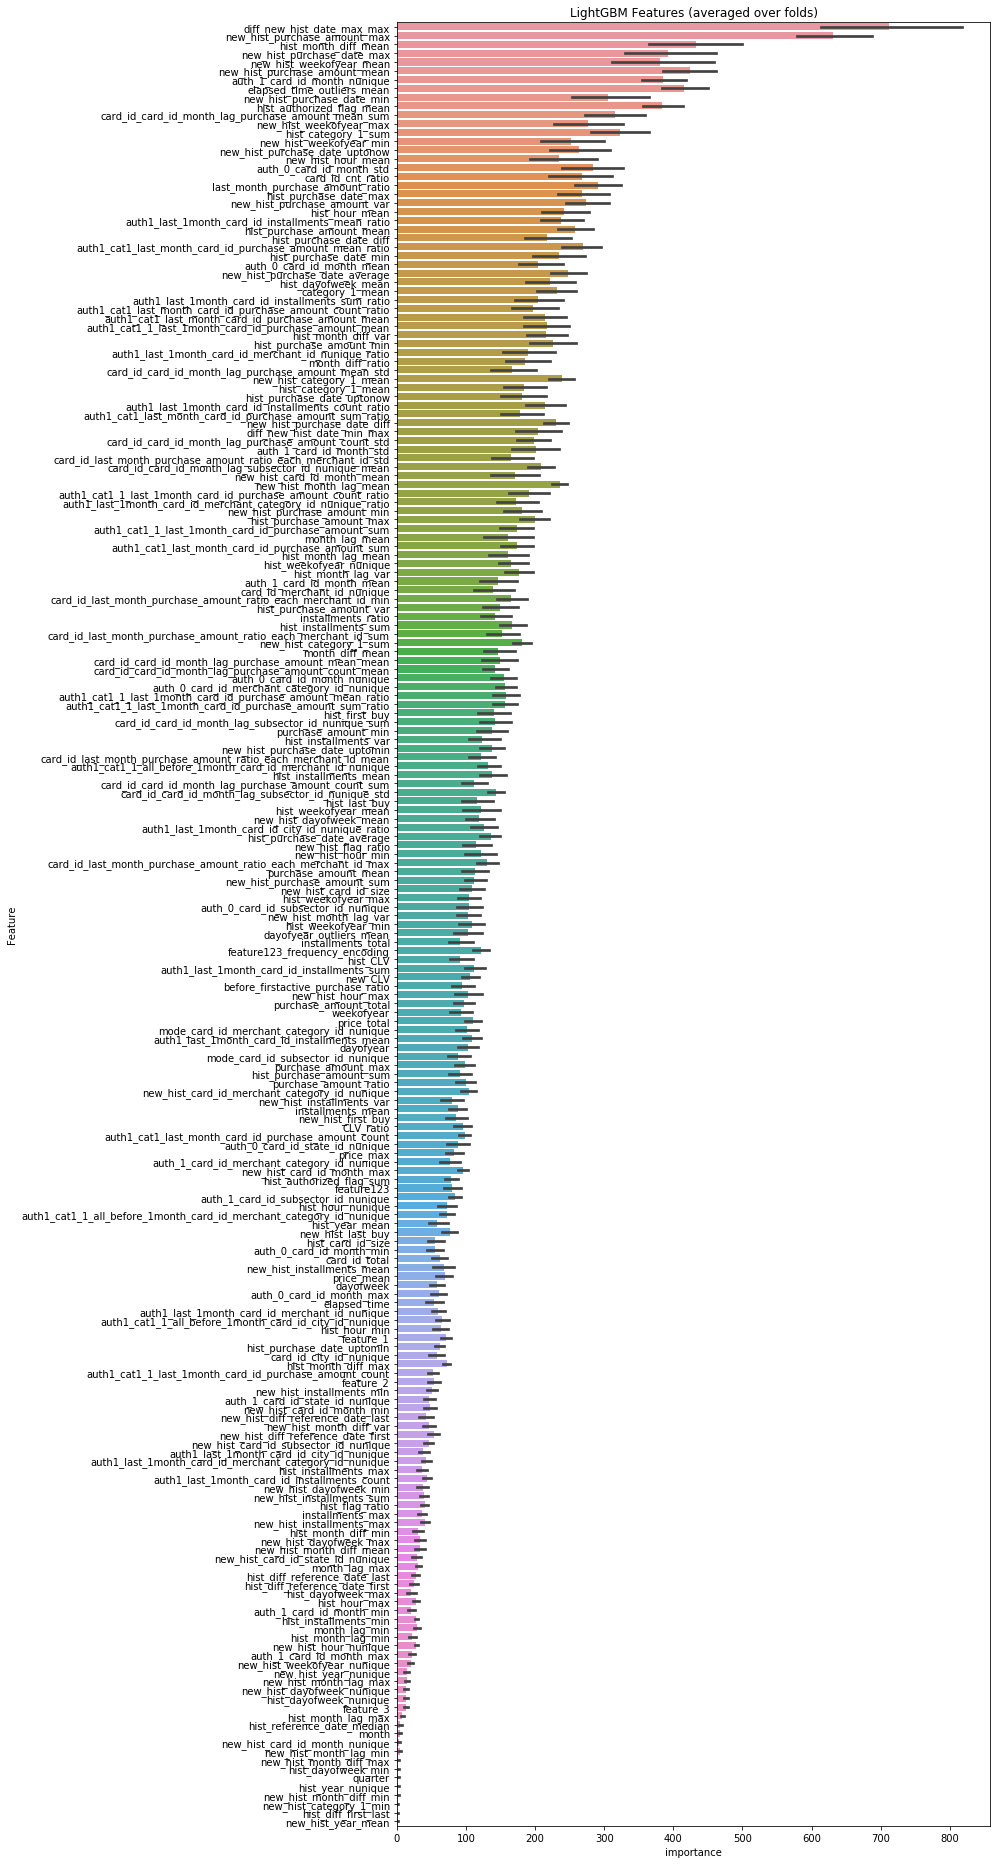

In [183]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [184]:
feature_importance_df.groupby('Feature')['importance'].sum().reset_index().sort_values('importance')

,Feature,importance
86,hist_diff_first_last,5
150,new_hist_category_1_min,8
170,new_hist_month_diff_max,10
193,new_hist_year_mean,10
172,new_hist_month_diff_min,14
203,quarter,15
126,hist_year_nunique,16
84,hist_dayofweek_min,18
145,new_hist_card_id_month_nunique,30
134,month,38


In [185]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df['target'] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("output/submission_{}.csv".format(filename), index=False)

# Post Processing

### without Outlier

In [46]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
train_df = train_df.loc[train_df['target']>-30]

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers',
                                                          'auth1_cat1_last_month_card_id_purchase_amount_mean',
 'auth1_cat1_last_month_card_id_purchase_amount_count',
 'auth1_cat1_last_month_card_id_purchase_amount_sum',
 'auth1_cat1_last_month_card_id_purchase_amount_mean_ratio',
 'auth1_cat1_last_month_card_id_purchase_amount_count_ratio',
 'auth1_cat1_last_month_card_id_purchase_amount_sum_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_mean',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_count',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_sum',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_mean_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_count_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_sum_ratio','auth1_cat1_1_all_before_1month_card_id_merchant_id_nunique',
 'auth1_last_1month_card_id_merchant_id_nunique',
 'auth1_last_1month_card_id_merchant_id_nunique_ratio',
                                                         
                                                         ]]
train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [47]:
train = train_df.copy()
target = train['target']
del train['target']

In [48]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.58747	valid_1's rmse: 1.57946
[200]	training's rmse: 1.55982	valid_1's rmse: 1.55655
[300]	training's rmse: 1.54578	valid_1's rmse: 1.54784
[400]	training's rmse: 1.53583	valid_1's rmse: 1.54383
[500]	training's rmse: 1.52779	valid_1's rmse: 1.54162
[600]	training's rmse: 1.52081	valid_1's rmse: 1.5407
[700]	training's rmse: 1.51436	valid_1's rmse: 1.54005
[800]	training's rmse: 1.50839	valid_1's rmse: 1.53953
[900]	training's rmse: 1.50271	valid_1's rmse: 1.53918
[1000]	training's rmse: 1.49713	valid_1's rmse: 1.53891
[1100]	training's rmse: 1.49178	valid_1's rmse: 1.53864
[1200]	training's rmse: 1.48668	valid_1's rmse: 1.53847
[1300]	training's rmse: 1.48163	valid_1's rmse: 1.5383
[1400]	training's rmse: 1.47671	valid_1's rmse: 1.5383
Early stopping, best iteration is:
[1374]	training's rmse: 1.47802	valid_1's rmse: 1.53816
fold 2
Training until validation scores don't improve for 100 round

[600]	training's rmse: 1.51779	valid_1's rmse: 1.56621
[700]	training's rmse: 1.51141	valid_1's rmse: 1.56532
[800]	training's rmse: 1.50542	valid_1's rmse: 1.56465
[900]	training's rmse: 1.49963	valid_1's rmse: 1.56417
[1000]	training's rmse: 1.49415	valid_1's rmse: 1.56389
[1100]	training's rmse: 1.48876	valid_1's rmse: 1.56361
[1200]	training's rmse: 1.48343	valid_1's rmse: 1.56339
[1300]	training's rmse: 1.47847	valid_1's rmse: 1.56323
[1400]	training's rmse: 1.47344	valid_1's rmse: 1.56308
[1500]	training's rmse: 1.46867	valid_1's rmse: 1.56295
[1600]	training's rmse: 1.46402	valid_1's rmse: 1.56291
[1700]	training's rmse: 1.45929	valid_1's rmse: 1.56284
[1800]	training's rmse: 1.45464	valid_1's rmse: 1.56282
[1900]	training's rmse: 1.45015	valid_1's rmse: 1.5628
Early stopping, best iteration is:
[1842]	training's rmse: 1.45271	valid_1's rmse: 1.56272
1.5532016598043572


1.5541206116854704

ratio 추가
1.5536569114204828

1.5534561554350272

'card_id_last_month_purchase_amount_ratio_each_merchant_id_min',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_max',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_sum',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_mean',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_std',
 'last_month_purchase_amount_ratio'
 
1.5533589631217688

1.5532016598043572

feature 8은 안좋아짐
1.554..

In [49]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = withoutoutlier_predictions

### outlier

In [71]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
#train_df = train_df.loc[train_df['target']>-30]

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers','last_month_purchase_amount_ratio',
                                                         'card_id_last_month_purchase_amount_ratio_each_merchant_id_min',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_max',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_sum',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_mean',
 'card_id_last_month_purchase_amount_ratio_each_merchant_id_std', # 여기까지 삭제하는 것이 제일 좋음
                                                         'auth1_cat1_last_month_card_id_purchase_amount_mean',
 'auth1_cat1_last_month_card_id_purchase_amount_count',
 'auth1_cat1_last_month_card_id_purchase_amount_sum',
 'auth1_cat1_last_month_card_id_purchase_amount_mean_ratio',
 'auth1_cat1_last_month_card_id_purchase_amount_count_ratio',
 'auth1_cat1_last_month_card_id_purchase_amount_sum_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_mean',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_count',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_sum',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_mean_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_count_ratio',
 'auth1_cat1_1_last_1month_card_id_purchase_amount_sum_ratio',
 'auth1_cat1_1_all_before_1month_card_id_merchant_id_nunique',
 'auth1_last_1month_card_id_merchant_id_nunique',
 'auth1_last_1month_card_id_merchant_id_nunique_ratio']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [72]:
train = train_df.copy()
target = train['outliers']
del train['target']
del train['outliers']

In [73]:
gbdt_param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "random_state": 6}

param = {'num_leaves': 128,
         'min_data_in_leaf': 50, 
         'objective':'binary',
         'max_depth': 9,
         'learning_rate': 0.1,
         "boosting": "rf",
         "feature_fraction": 0.6,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "random_state": 6}

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_+1))

    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(gbdt_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.6f}".format(log_loss(target, oof)))

fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0445298	valid_1's binary_logloss: 0.0474313
[200]	training's binary_logloss: 0.0411118	valid_1's binary_logloss: 0.0450948
[300]	training's binary_logloss: 0.0391712	valid_1's binary_logloss: 0.0444177
[400]	training's binary_logloss: 0.0377888	valid_1's binary_logloss: 0.0441654
[500]	training's binary_logloss: 0.0365649	valid_1's binary_logloss: 0.0440653
[600]	training's binary_logloss: 0.0354308	valid_1's binary_logloss: 0.0439706
[700]	training's binary_logloss: 0.0343632	valid_1's binary_logloss: 0.0439558
[800]	training's binary_logloss: 0.0333089	valid_1's binary_logloss: 0.0439396
[900]	training's binary_logloss: 0.0324007	valid_1's binary_logloss: 0.0439879
[1000]	training's binary_logloss: 0.0314276	valid_1's binary_logloss: 0.0440169
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.0332753	valid_1's binary_logloss: 0.0439395
fold 2
Training until val

CV score: 0.043457


gdbt
0.043527
CV score: 0.043523

20190214
0.043457


rf
CV score: 0.151194



In [74]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.sort_values('target',ascending=False)

,card_id,target
104991,C_ID_86ddafb51c,0.652219
32446,C_ID_ac114ef831,0.647792
20556,C_ID_aae50409e7,0.621640
37421,C_ID_366bf4ea4d,0.604123
5008,C_ID_be92f84f5c,0.594972
19114,C_ID_0be3fb41d2,0.594809
27384,C_ID_1a23d403c3,0.589626
54793,C_ID_761c27a0f2,0.567739
80840,C_ID_bced41d837,0.560360
88371,C_ID_26f775a95b,0.552046


현우님과 아웃라이어 모델 섞는 모델

In [266]:
hyeonwoo_outlier = pd.read_csv('hyeonwoo_outlier_cv0.043527.csv')
hyeonwoo_outlier.sort_values('target',ascending=False)

,card_id,target
20556,C_ID_aae50409e7,0.612718
32446,C_ID_ac114ef831,0.578900
41138,C_ID_d706b6696a,0.572661
104991,C_ID_86ddafb51c,0.572087
114106,C_ID_e54aeb08f7,0.564345
119449,C_ID_3d40705001,0.557863
84189,C_ID_979347c28f,0.538942
5008,C_ID_be92f84f5c,0.537628
96354,C_ID_b237ce01cb,0.525527
77945,C_ID_6ab591cf62,0.510256


In [279]:
print("yeonmin", len(df_outlier_prob.loc[df_outlier_prob['target']>0.48,'card_id'].values))
print("hyeonwoo", len(hyeonwoo_outlier.loc[hyeonwoo_outlier['target']>0.48,'card_id'].values))

yeonmin 30
hyeonwoo 19


In [281]:
top26_outlier = set(df_outlier_prob.loc[df_outlier_prob['target']>0.48,'card_id'].values).union(set(hyeonwoo_outlier.loc[hyeonwoo_outlier['target']>0.48,'card_id'].values))
len(top26_outlier)

38

In [282]:
ym_top_30000 = set(df_outlier_prob.sort_values('target', ascending=False).head(30000)['card_id'].values)
hyeonwoo_top_30000 = set(hyeonwoo_outlier.sort_values('target', ascending=False).head(30000)['card_id'].values)
outlier_id_temp = pd.DataFrame(list(ym_top_30000.intersection(hyeonwoo_top_30000)),columns=['card_id'])
outlier_id_temp.shape

(26853, 1)

In [283]:
outlier_id = outlier_id_temp.copy()

single 671과 섞는 방법

In [75]:
outlier_id = pd.read_csv('best_lb_outlier_id.csv')
top20_outlier_id = pd.read_csv('best_lb_top20_outlier_id.csv')
#youhan_outlier = pd.read_csv('input/youhan_outlier.csv')
#outlier_id = pd.DataFrame(df_outlier_prob.sort_values('target',ascending=False).head(30000)['card_id'])

In [76]:
outlier_id_temp = pd.DataFrame(list(set(df_outlier_prob.loc[df_outlier_prob['target']>0.00203,'card_id'].values).intersection(set(outlier_id['card_id'].values))),columns=['card_id'])
outlier_id_temp.shape

(28095, 1)

In [57]:
outlier_id = outlier_id_temp.copy()

In [58]:
top26_outlier = list(set(df_outlier_prob.loc[df_outlier_prob['target']>0.5,'card_id'].values).union(set(top20_outlier_id['card_id'].values)))
len(top26_outlier)

38

### Best Submission

In [61]:
hyeonwoo_without_outlier = pd.read_csv('hyeonwoo_without_outlier_cv1.553025268039643.csv')
hyeonwoo_without_outlier.columns = ['card_id', 'h_target']

In [62]:
combine_hy_without_outlier = model_without_outliers.merge(hyeonwoo_without_outlier, on='card_id',how='left')
combine_hy_without_outlier['target'] = combine_hy_without_outlier['target']*0.5 + combine_hy_without_outlier['h_target']*0.5
del combine_hy_without_outlier['h_target']

In [63]:
hyeonwoo_best = pd.read_csv('output/v7_3.646642609714585.csv')
#hyeonwoo_best2 = pd.read_csv('output/FFM_MERCHANT.csv')
#print(hyeonwoo_best['target'].corr(hyeonwoo_best2['target']))
#hyeonwoo_best['target'] = hyeonwoo_best['target']*0.5 + hyeonwoo_best2['target']*0.5

In [64]:
my_best = pd.read_csv('output/submission_20190213_175946_cv3.639846.csv') # lb 3.678
#my_best2 = pd.read_csv('output/submission_20190213_175946_cv3.639846.csv') # lb 3.676
#print(my_best['target'].corr(my_best2['target']))
#my_best['target'] = my_best['target']*0.4 + my_best2['target']*0.6

현우님 blend model lb 추정 3.678~679
내꺼 blend model lb 추정 3.675~3.676

In [65]:
hyeonwoo_best['target'].corr(my_best['target'])

0.965890421664523

In [66]:
my_best['target'] = hyeonwoo_best['target']*0.55 + my_best['target']*0.45
best_submission = my_best.copy()
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [67]:
only_without_outliers = combine_hy_without_outlier.loc[~combine_hy_without_outlier['card_id'].isin(most_likely_liers['card_id'].unique())]
submission = pd.concat([only_without_outliers, most_likely_liers])

In [68]:
filename = '{}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'))
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df = sub_df.merge(submission, on='card_id',how='left')
sub_df.loc[sub_df['card_id'].isin(top26_outlier),'target'] = -33.21928095
sub_df.to_csv("output/{}_submission_blend_blend.csv".format(filename), index=False)

In [69]:
sub_df.shape

(123623, 2)

In [70]:
sub_df.loc[sub_df['target']<-30].shape

(38, 2)